In [ ]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
import torchvision
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt

$\Large\textbf{Variational Auto Encoder Architecture}$

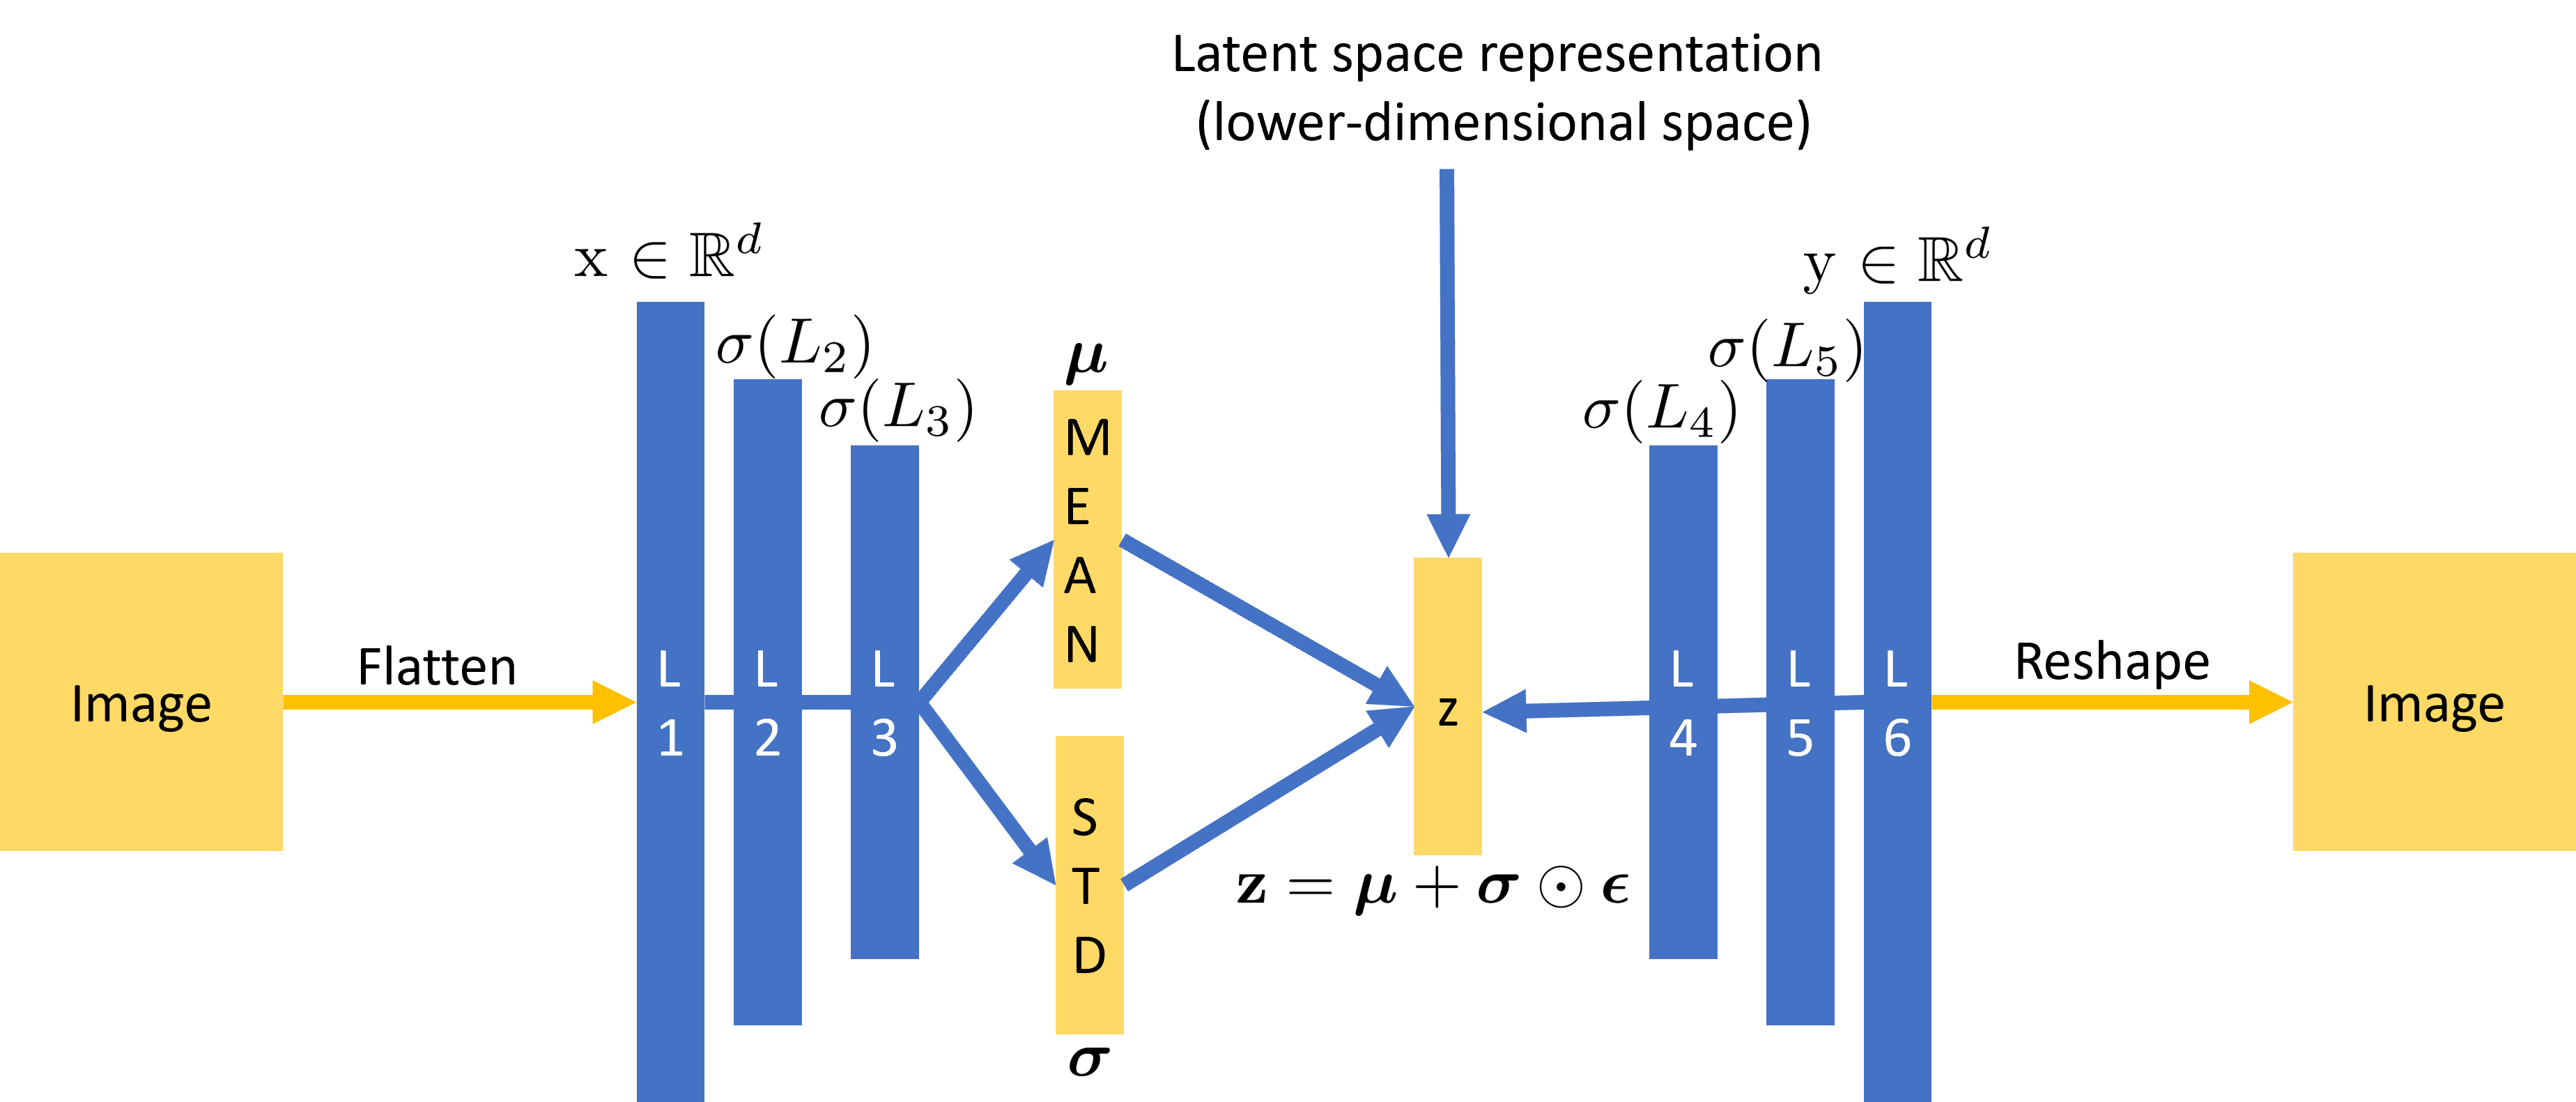

## 1. Total Loss

- Total loss in VAE is $ \text{L}_{\text{vae}} = \text{L}_{\text{reconstruction}} + \alpha \times \text{L}_{\text{kl}}.$

-  $\text{L}_{\text{reconstruction}} $ measures how well the VAE reconstructs the input.

- $\text{L}_{\text{kl}}$  regularizes the latent space to follow the standard normal distribution.



## 2. Reparameterization Trick

- $ \mathbf{z} = \boldsymbol{\mu}$ + $\boldsymbol{\sigma}$ $\odot \boldsymbol{\epsilon}$ , where  $\boldsymbol{\epsilon} \sim \mathcal{N}(0, 1) $ and  $\sigma = e^{\frac{\log(\sigma^2)}{2}}.$



## 3. Reconstruction Loss

$
\text{L}_{\text{MSE}} = \|\mathbf{x} - \mathbf{y}\|^2_2
$



## 4. KL Divergence with respect to $\mathcal{N}(0, 1) $

$
\text{L}_{\text{KL}}(\mu, \sigma) = -\frac{1}{2} \sum_{j=1}^J \left( 1 + \log(\sigma_j^2) - \mu_j^2 - \sigma_j^2 \right)
$


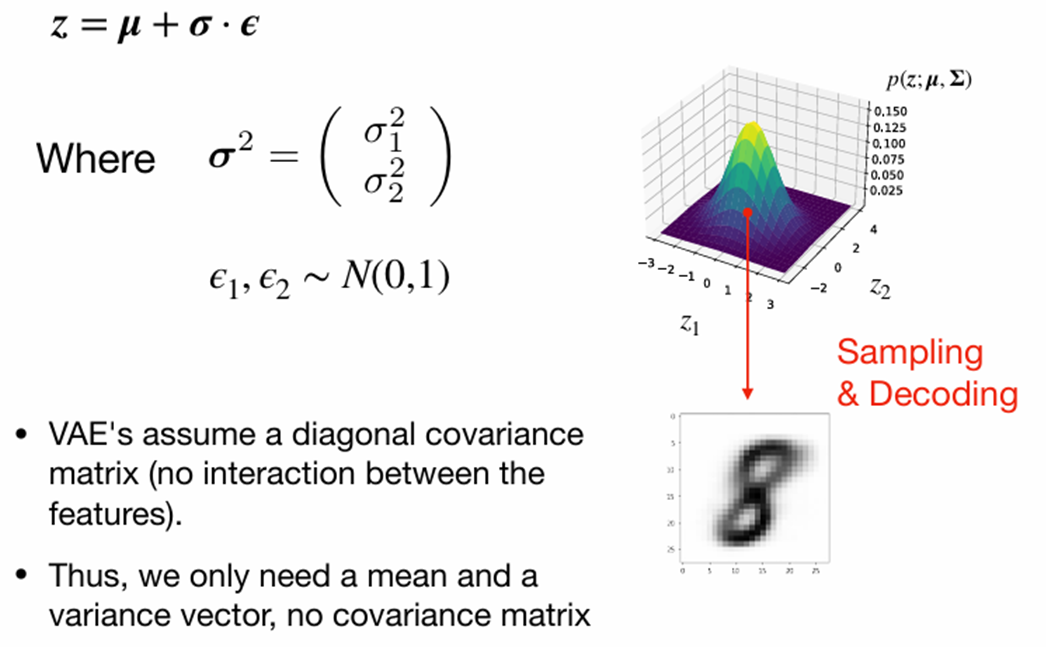

Image Source: https://sebastianraschka.com/pdf/lecture-notes/stat453ss21/L17_vae__slides.pdf

In [4]:
# @title Latent Space Visualization of variational autoencoder
from IPython.display import display, HTML

# URL of the GIF
gif_url = "https://giphy.com/embed/lqq0em9cuivVNWFwSX"

# Display the GIF in a smaller window
display(HTML(f'<div style="width:50%;height:0;padding-bottom:43%;position:relative;"><iframe src="{gif_url}" width="100%" height="100%" style="position:absolute" frameBorder="0" class="giphy-embed" allowFullScreen></iframe></div>'))


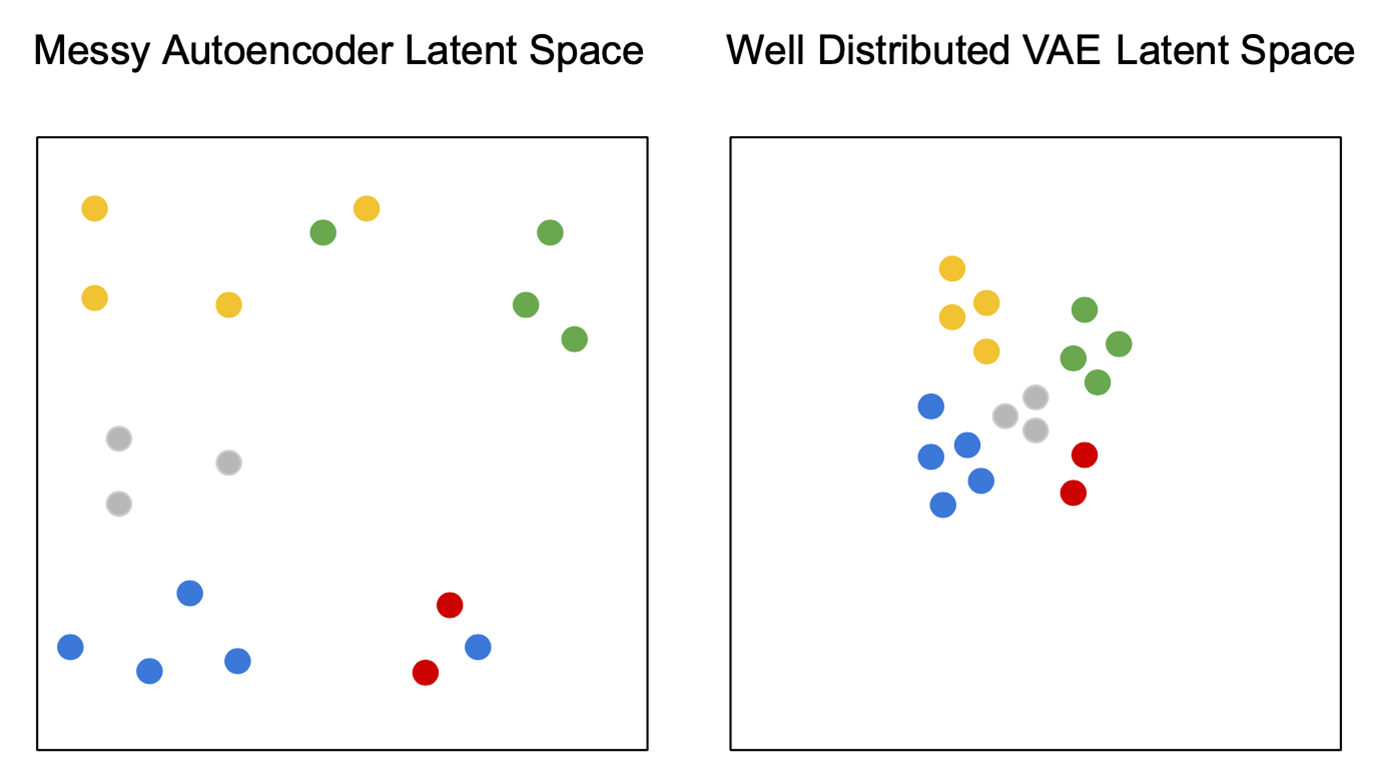

The two images of the same number let say 2 written by different people, $ z_{Alice} $ and $ z_{Bob} $ could end up with very different representations $ z_{Alice}, z_{Bob} $ in $\textbf{Auto Encoders}$. $\textbf{The Variational AutoEncoder}$ representation space of $ z $ is meaningful. This has the effect of keeping similar numbers' representations close together (e.g the representation of digit two $ z_{Alice}, z_{Bob} $ remain sufficiently close).


Blog About VAE: https://jaan.io/what-is-variational-autoencoder-vae-tutorial/

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
# functions to show an image

def imshow(img, title = False):

    plt.imshow(np.transpose(img, (1, 2, 0)))
    if(title):
        plt.title("{}".format(title))
    plt.show()


# MNIST dataset

In [ ]:
TrainData = datasets.MNIST('../data/', download=True, transform=transforms.ToTensor(), train=True)
train_loader = torch.utils.data.DataLoader(TrainData,batch_size=34)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.1MB/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 485kB/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.41MB/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 9.55MB/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



# VAE Model

In [ ]:
class VAE(nn.Module):
    def __init__(self, image_size, channel_num, z_size):
        super().__init__()

        # Initialize configurations
        self.image_size = image_size
        self.channel_num = channel_num
        self.z_size = z_size
        self.num_encoder_layers = 2

        # Encoder
        self.conv1 = nn.Conv2d(in_channels=channel_num, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1)
        self.relu2 = nn.ReLU()


        # Now we get the compressed feature representation from encoder of size [batch_size, 128, 7, 7].

        # Encoded feature's size and volume
        self.feature_size = image_size // (2 ** self.num_encoder_layers)  # 28 // 2**2 = 7
        self.feature_volume = 128 * (self.feature_size ** 2)              # 128 * 7**2 = 6272

        # Feature volume (128 * 7 * 7 = 6272) is flattened to form the input to the latent space layer.

        # Latent space: Mean and log variance
        self.q_mean_fc = nn.Linear(self.feature_volume, z_size)

        # log of variance for numerical stability
        self.q_logvar_fc = nn.Linear(self.feature_volume, z_size)

        # Trhe latent space z is projected back to feature space of size 6272.
        self.project_fc = nn.Linear(z_size, self.feature_volume)

        # Decoder
        self.deconv1 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.relu3 = nn.ReLU()

        self.deconv2 = nn.ConvTranspose2d(in_channels=64, out_channels=channel_num, kernel_size=4, stride=2, padding=1)
        self.relu4 = nn.ReLU()

    def forward(self, x):

        # Encoding
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)

        # Flatten the encoded features
        encoded_flat = x.view(-1, self.feature_volume)

        # Compute mean and log variance of latent variables
        mean = self.q_mean_fc(encoded_flat)
        logvar = self.q_logvar_fc(encoded_flat)

        # Sample latent vector z
        z = self.reparameterize(mean, logvar)

        # Project latent vector to feature volume
        z_projected = self.project_fc(z).view(-1, 128, self.feature_size, self.feature_size)

        # Decoding
        x_reconstructed = self.deconv1(z_projected)
        x_reconstructed = self.relu3(x_reconstructed)
        x_reconstructed = self.deconv2(x_reconstructed)
        x_reconstructed = self.relu4(x_reconstructed)

        return mean, logvar, x_reconstructed


    # Reparameterization trick: z = mean + std * epsilon
    def reparameterize(self, mean, logvar):

        # Since we have already seen the formulae of sigma is e^((1/2)(log(sigma^2))) where log(sigma^2 is logvar
        std = torch.exp(0.5 * logvar)

        eps = torch.randn_like(std)
        return mean + eps * std

    # Reconstruction loss is Mean Squared Error (MSE)
    def reconstruction_loss(self, x_reconstructed, x):

        mse_loss = (x_reconstructed - x) ** 2

        # Sum the loss over all pixels and divide by the batch size
        loss = mse_loss.sum() / x.size(0)

        return loss


    def kl_divergence_loss(self, mean, logvar):

        # KL Divergence = 0.5 * sum(1 + log(var) - mean^2 - var)
        kl_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())

        return kl_loss / mean.size(0)  # Average the KL loss across the batch

In [ ]:
model = VAE(image_size = 28, channel_num = 1, z_size = 8).to(device)
optimizer_vae = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-3)

# Train Function

In [ ]:
def train(epoch):
    train_loss = 0
    recon_loss = 0
    kl_loss = 0
    recon_batch = None
    for batch_idx, (data, classes) in enumerate(train_loader):

            data, classes = data.to(device), classes.to(device)
            optimizer_vae.zero_grad()
            mu, logvar, recon_batch = model(data)

            reconstruction_loss = model.reconstruction_loss(recon_batch, data)
            kl_divergence_loss = model.kl_divergence_loss(mu, logvar)
            recon_loss += reconstruction_loss.item()
            loss = reconstruction_loss + kl_divergence_loss #+ 100*quantile_loss
            kl_loss += kl_divergence_loss.item()
            loss.backward()
            train_loss += loss.item()
            optimizer_vae.step()

    print('====> Epoch: {} Average loss: {:.4f}'.format(
        epoch, train_loss / (len(train_loader)*20)))
    print('====> Epoch: {} Average Reconstruction loss: {:.4f}'.format(
        epoch, recon_loss / (len(train_loader)*20)))
    print('====> Epoch: {} Average KL loss: {:.4f}'.format(
        epoch, kl_loss / (len(train_loader)*20)))


    print('Original Samples:')
    imshow(torchvision.utils.make_grid(data.cpu()))
    print('Generated Generated:')
    imshow(torchvision.utils.make_grid(recon_batch.view(-1,1,28,28).detach().cpu()))
    print('='*200)

====> Epoch: 1 Average loss: 2.0784
====> Epoch: 1 Average Reconstruction loss: 1.6881
====> Epoch: 1 Average KL loss: 0.3903
Original Samples:


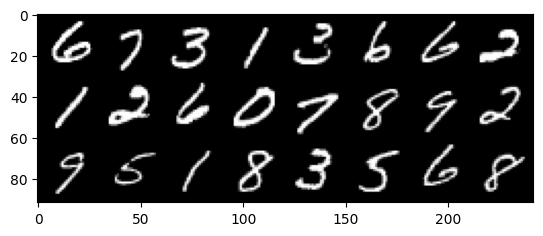

Generated Generated:


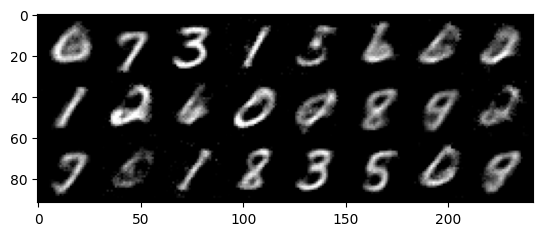

====> Epoch: 2 Average loss: 1.6737
====> Epoch: 2 Average Reconstruction loss: 1.2063
====> Epoch: 2 Average KL loss: 0.4674
Original Samples:


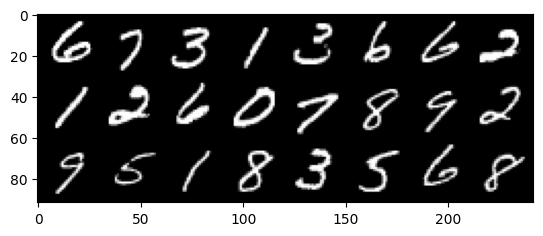

Generated Generated:


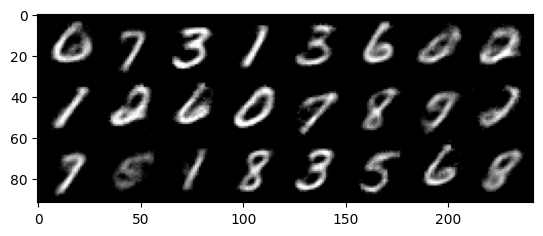

====> Epoch: 3 Average loss: 1.6238
====> Epoch: 3 Average Reconstruction loss: 1.1399
====> Epoch: 3 Average KL loss: 0.4840
Original Samples:


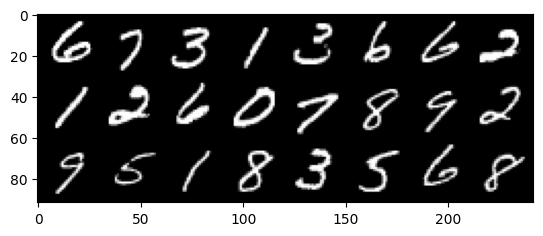

Generated Generated:


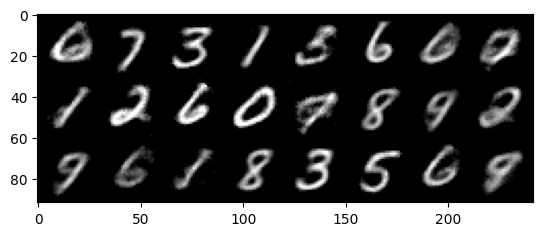

====> Epoch: 4 Average loss: 1.5951
====> Epoch: 4 Average Reconstruction loss: 1.0998
====> Epoch: 4 Average KL loss: 0.4953
Original Samples:


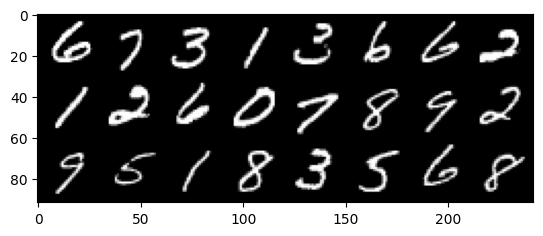

Generated Generated:


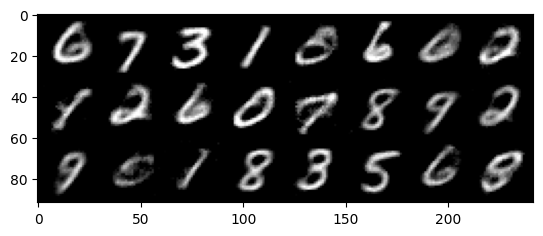

====> Epoch: 5 Average loss: 1.5744
====> Epoch: 5 Average Reconstruction loss: 1.0717
====> Epoch: 5 Average KL loss: 0.5027
Original Samples:


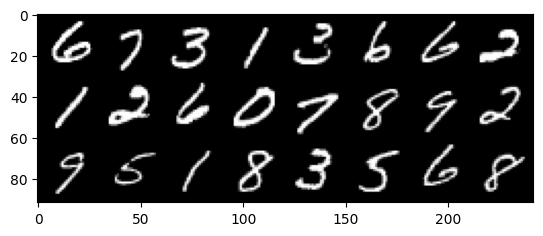

Generated Generated:


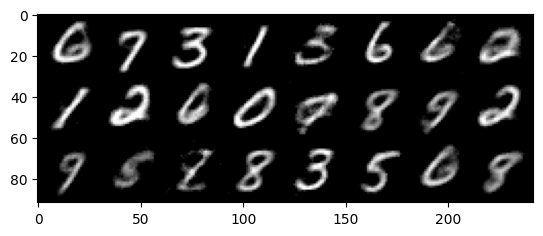

====> Epoch: 6 Average loss: 1.5590
====> Epoch: 6 Average Reconstruction loss: 1.0503
====> Epoch: 6 Average KL loss: 0.5087
Original Samples:


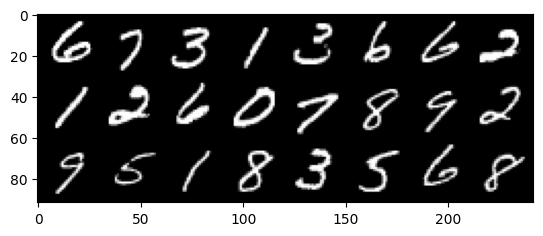

Generated Generated:


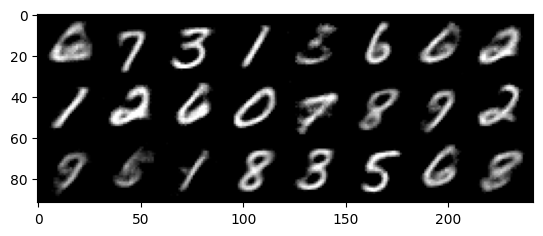

====> Epoch: 7 Average loss: 1.5462
====> Epoch: 7 Average Reconstruction loss: 1.0333
====> Epoch: 7 Average KL loss: 0.5129
Original Samples:


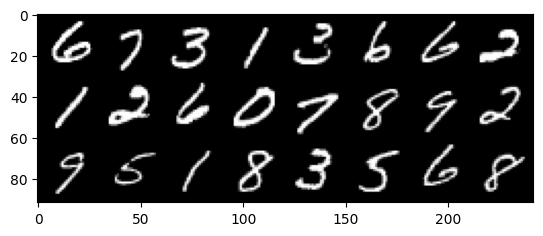

Generated Generated:


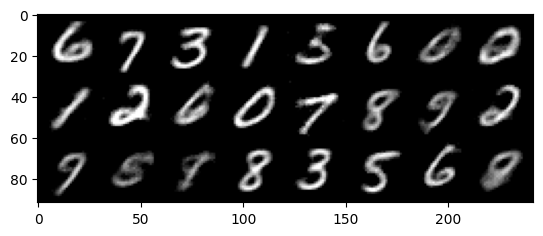

====> Epoch: 8 Average loss: 1.5349
====> Epoch: 8 Average Reconstruction loss: 1.0184
====> Epoch: 8 Average KL loss: 0.5165
Original Samples:


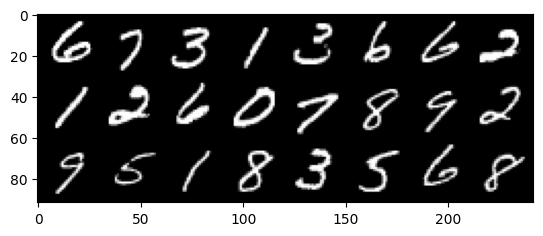

Generated Generated:


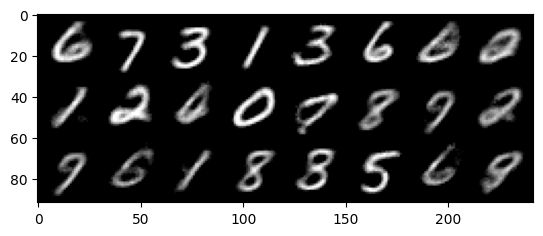

====> Epoch: 9 Average loss: 1.5270
====> Epoch: 9 Average Reconstruction loss: 1.0064
====> Epoch: 9 Average KL loss: 0.5206
Original Samples:


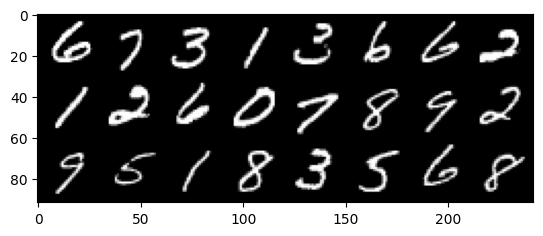

Generated Generated:


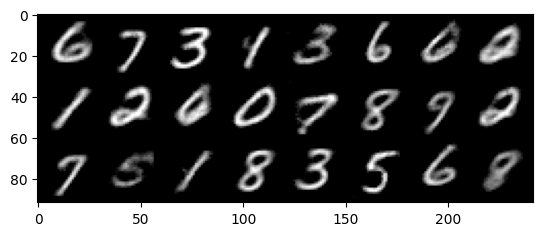

====> Epoch: 10 Average loss: 1.5190
====> Epoch: 10 Average Reconstruction loss: 0.9968
====> Epoch: 10 Average KL loss: 0.5222
Original Samples:


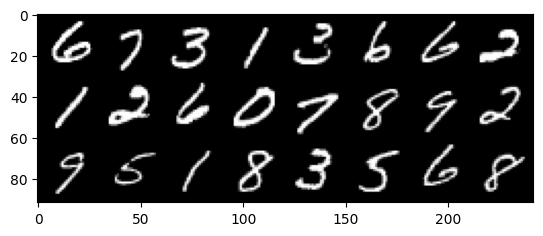

Generated Generated:


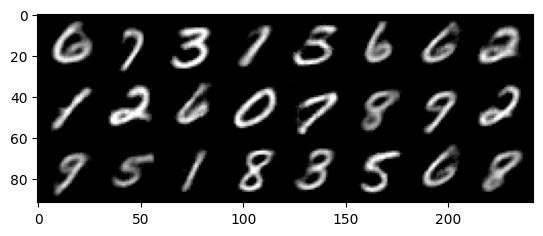

In [ ]:
epochs = 10
for epoch in range(1, epochs + 1):
    train(epoch)

#Evaluating decoder on a random input

Input Random Sample tensor([-0.8517, -0.6035, -0.5138, -0.3818,  0.0750,  0.3109, -0.7101,  0.0647],
       device='cuda:0')
The shape of the projeced latent space torch.Size([1, 128, 7, 7])
Generated Image Shape: torch.Size([1, 1, 28, 28])
Generated Image:


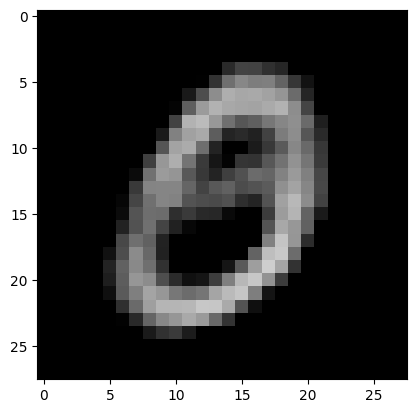

In [ ]:
z_size = 8 #torch.Size([5,8])
image_size = 28
num_encoder_layers = 2
feature_size = image_size // (2**num_encoder_layers)


rand_sample = torch.randn(z_size).to(device)

print("Input Random Sample", rand_sample)
print('='*200)


z_projected = model.project_fc(rand_sample).view(-1, 128, feature_size, feature_size).to(device)

print("The shape of the projeced latent space", z_projected.shape)
print('='*200)

# Reconstruct x from z

# Decode the projected latent vector back to the image
x_generated = model.deconv1(z_projected)
x_generated = model.relu3(x_generated)
x_generated = model.deconv2(x_generated)
x_generated = model.relu4(x_generated)

print('Generated Image Shape:', x_generated.shape)

# Visualize the generated image
print('Generated Image:')
grid = torchvision.utils.make_grid(x_generated.view(-1, 1, 28, 28).detach().cpu())
plt.imshow(grid.permute(1, 2, 0))  # Convert the grid for displaying
plt.show()